In this notebook, the model was fine-tuned for competition dataset m4-weekly, with 2598 timestamps in length, and in total 359 of them from different domains. Their lengths also vary, empty values padded with null at the end.

Since Lag-llama performs well on m4weekly (little deviation, input-sensitive, probablisitic fan-out), the testing was done on test_ds, instead of train_ds.

Also, learning rate scheduler was activated and experimented with different T_max values.

<img src="./m4datasets_overview.jpg" alt="m4 datasets" width="600"/>


In [1]:
# Load libraries

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
import os
import wandb
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/tmp/ipykernel_13999/2249698634.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# import training datasets from m4_weekly datasets

dataset = get_dataset("m4_weekly")
train_ds = dataset.train
test_ds = dataset.test

In [4]:
len(train_ds) # 359 trajectories from different domains 
#print(type(train_ds))
#print(train_ds.iterable.line_starts)
#plt.plot(train_ds.iterable.line_starts)

359

In [3]:
def getCPRS(dataset, predictor, num_samples=100):
    forecast_it, ts_it = make_evaluation_predictions( 
            dataset=dataset,
            predictor=predictor,
            num_samples=num_samples)
            
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))
    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    # plot
    plt.figure(figsize=(20, 40))
    date_formater = mdates.DateFormatter('%b, %d')
    plt.rcParams.update({'font.size': 15})
    # Iterate through the first 9 series, and plot the predicted samples 
    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 40):
        ax = plt.subplot(20, 2, idx+1)
    
        plt.plot(ts[-6 * 24:].to_timestamp(), label="target", )
        forecast.plot(color='g')
        plt.xticks()
        ax.xaxis.set_major_formatter(date_formater)
    return agg_metrics['mean_wQuantileLoss']

### m4_weekly fine-tuning

In [3]:
# define the hyperparameters

prediction_length = 24
context_length = 96
num_samples = 100
lr=10e-5
batch_size=32
trainer_kwargs={"max_epochs": 150}

device = "cuda:0"
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

In [11]:
# initialize the estimator

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    nonnegative_pred_samples=True,
    aug_prob=0,
    lr=lr,
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],
    
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=batch_size,
    num_parallel_samples=num_samples,
    trainer_kwargs=trainer_kwargs,
    
    use_cosine_annealing_lr=True, # just for lr_scheduler
    cosine_annealing_lr_args={"T_max": 500}, # T_max: maximum number of iterations #epoch x #steps
)

# train the estimator
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.

Training: |                                               | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 6.88897 (best 6.88897), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lightning_logs/version_128/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 6.30480 (best 6.30480), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lightning_logs/version_128/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 6.07109 (best 6.07109), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lightning_logs/version_128/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 6.00260 (best 6.00260), saving model to '/home/eragroup/Documents/Documents/Kouta

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]


Running evaluation: 359it [00:00, 3310.98it/s]
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up 

0.07046710296705735


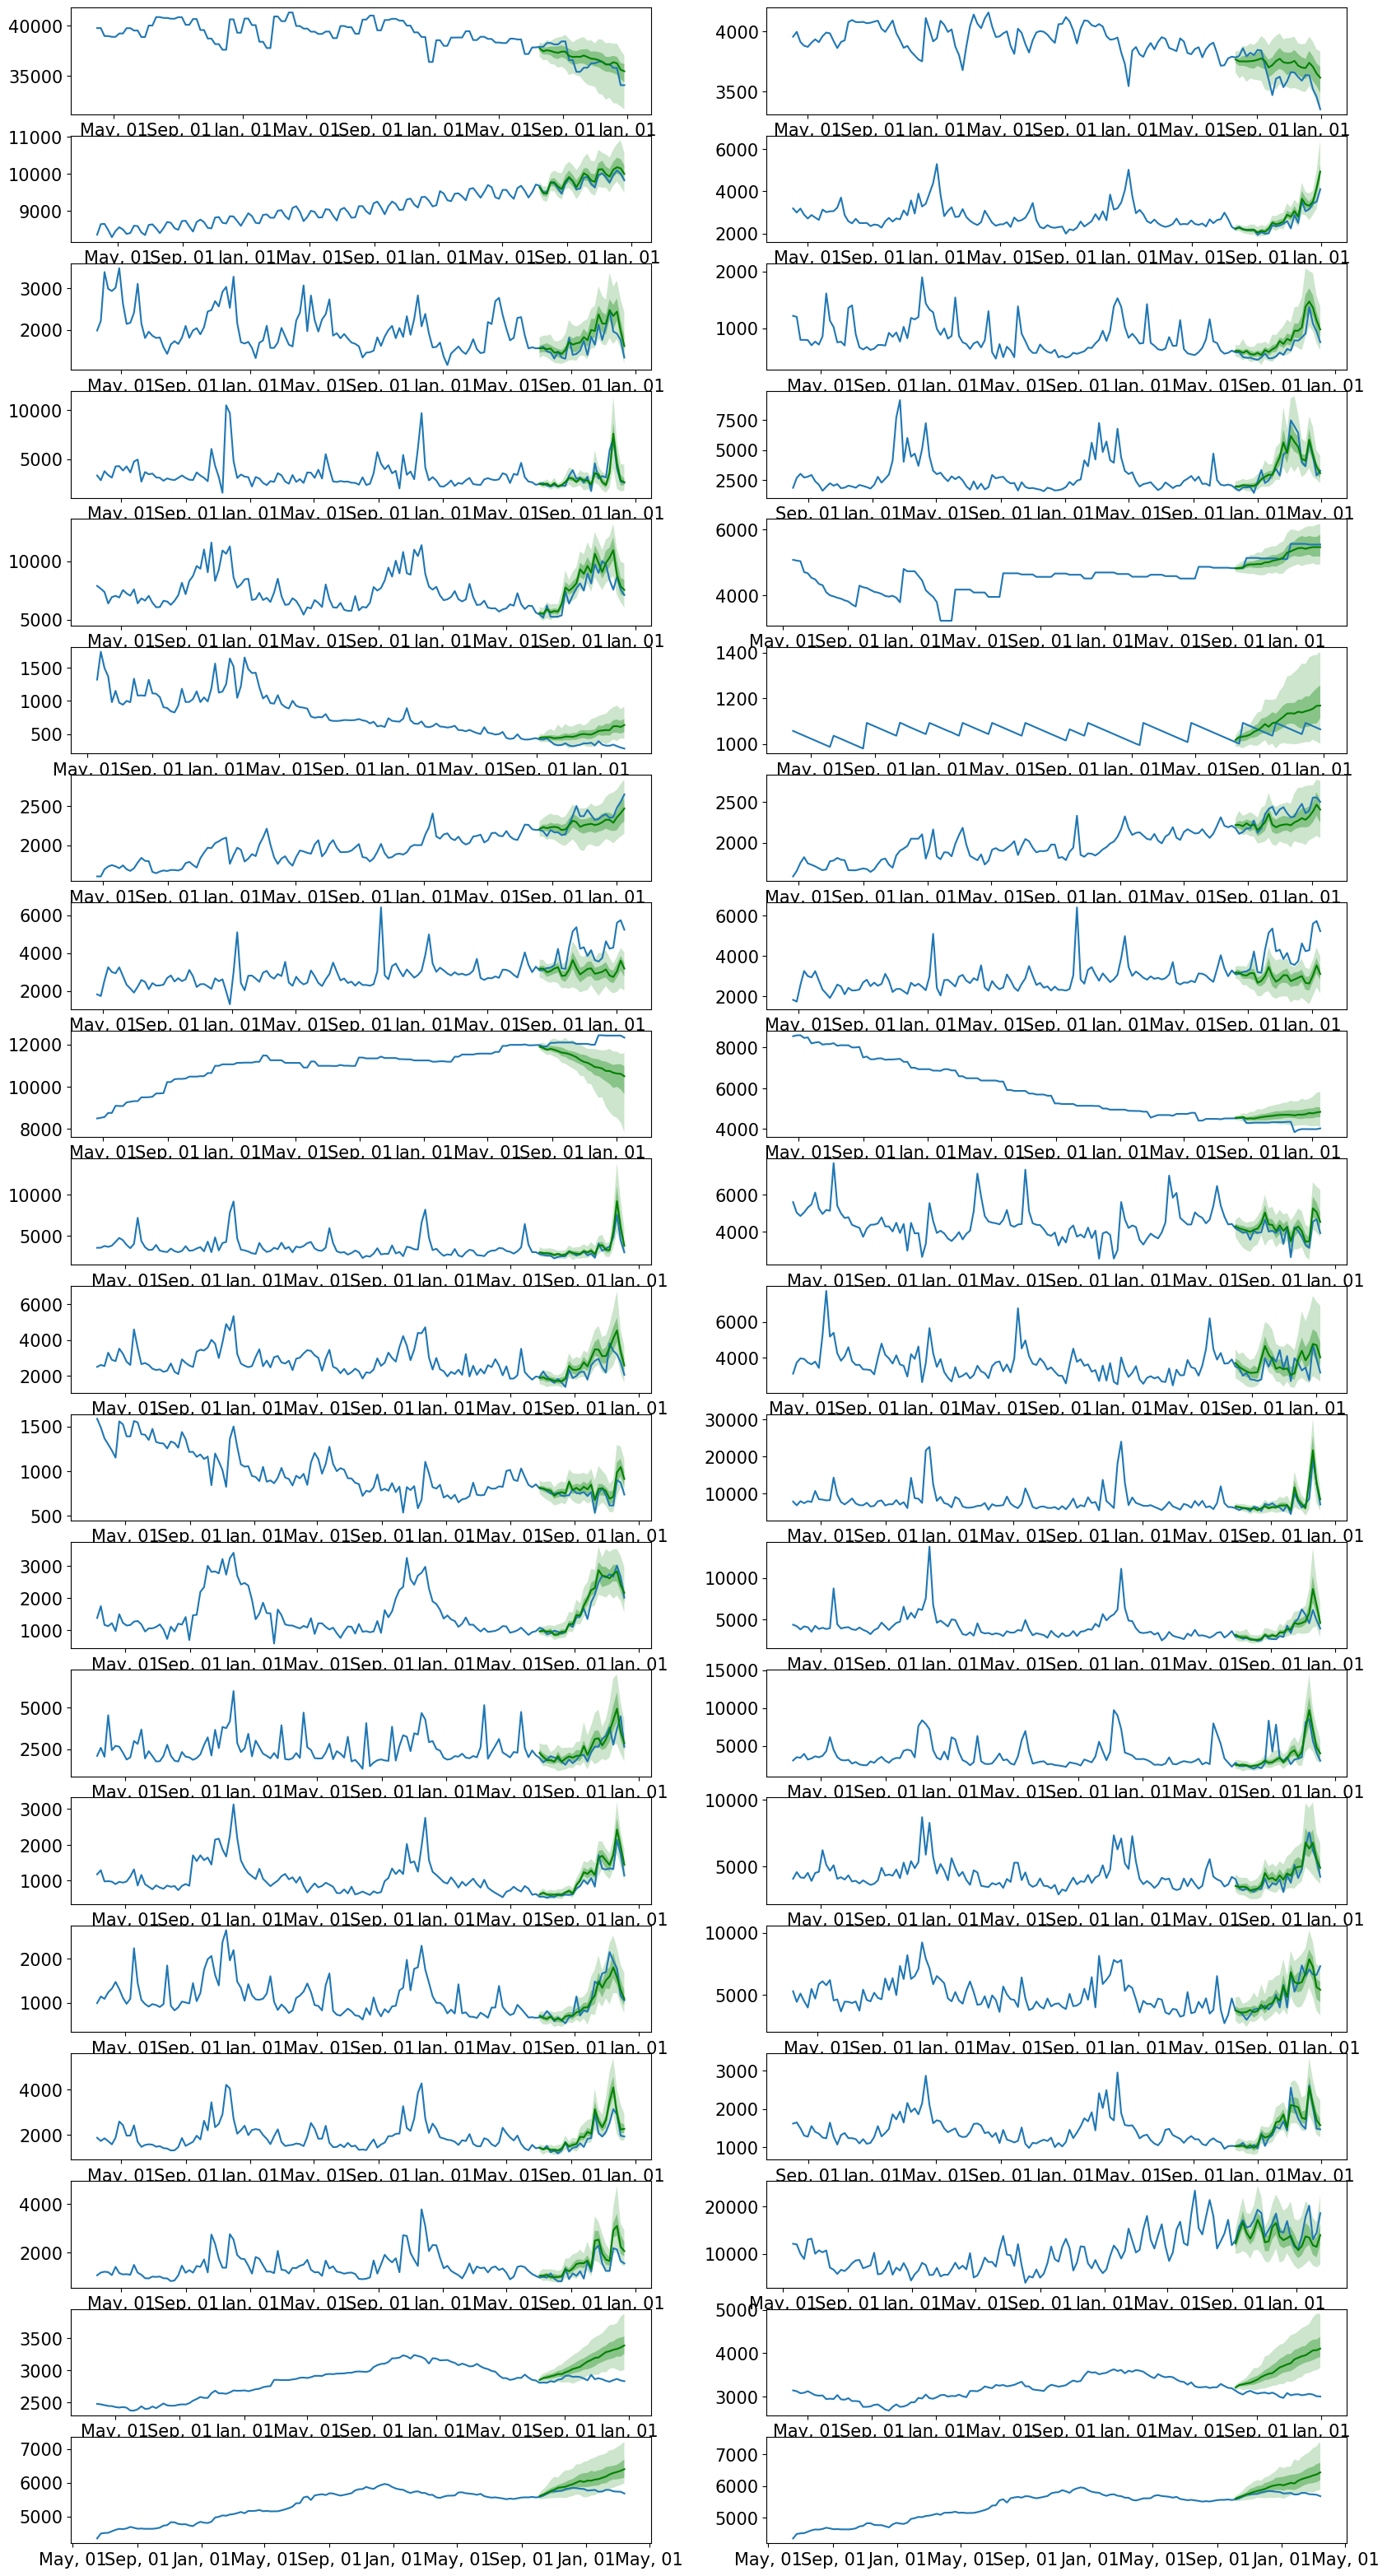

In [35]:
print(getCPRS(test_ds, predictor, )) # fixed lr, tested on test_ds
# CRPS: 0.07046710296705735 

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]

Running evaluation: 359it [00:00, 3484.25it/s]
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up s

0.10545857256570328


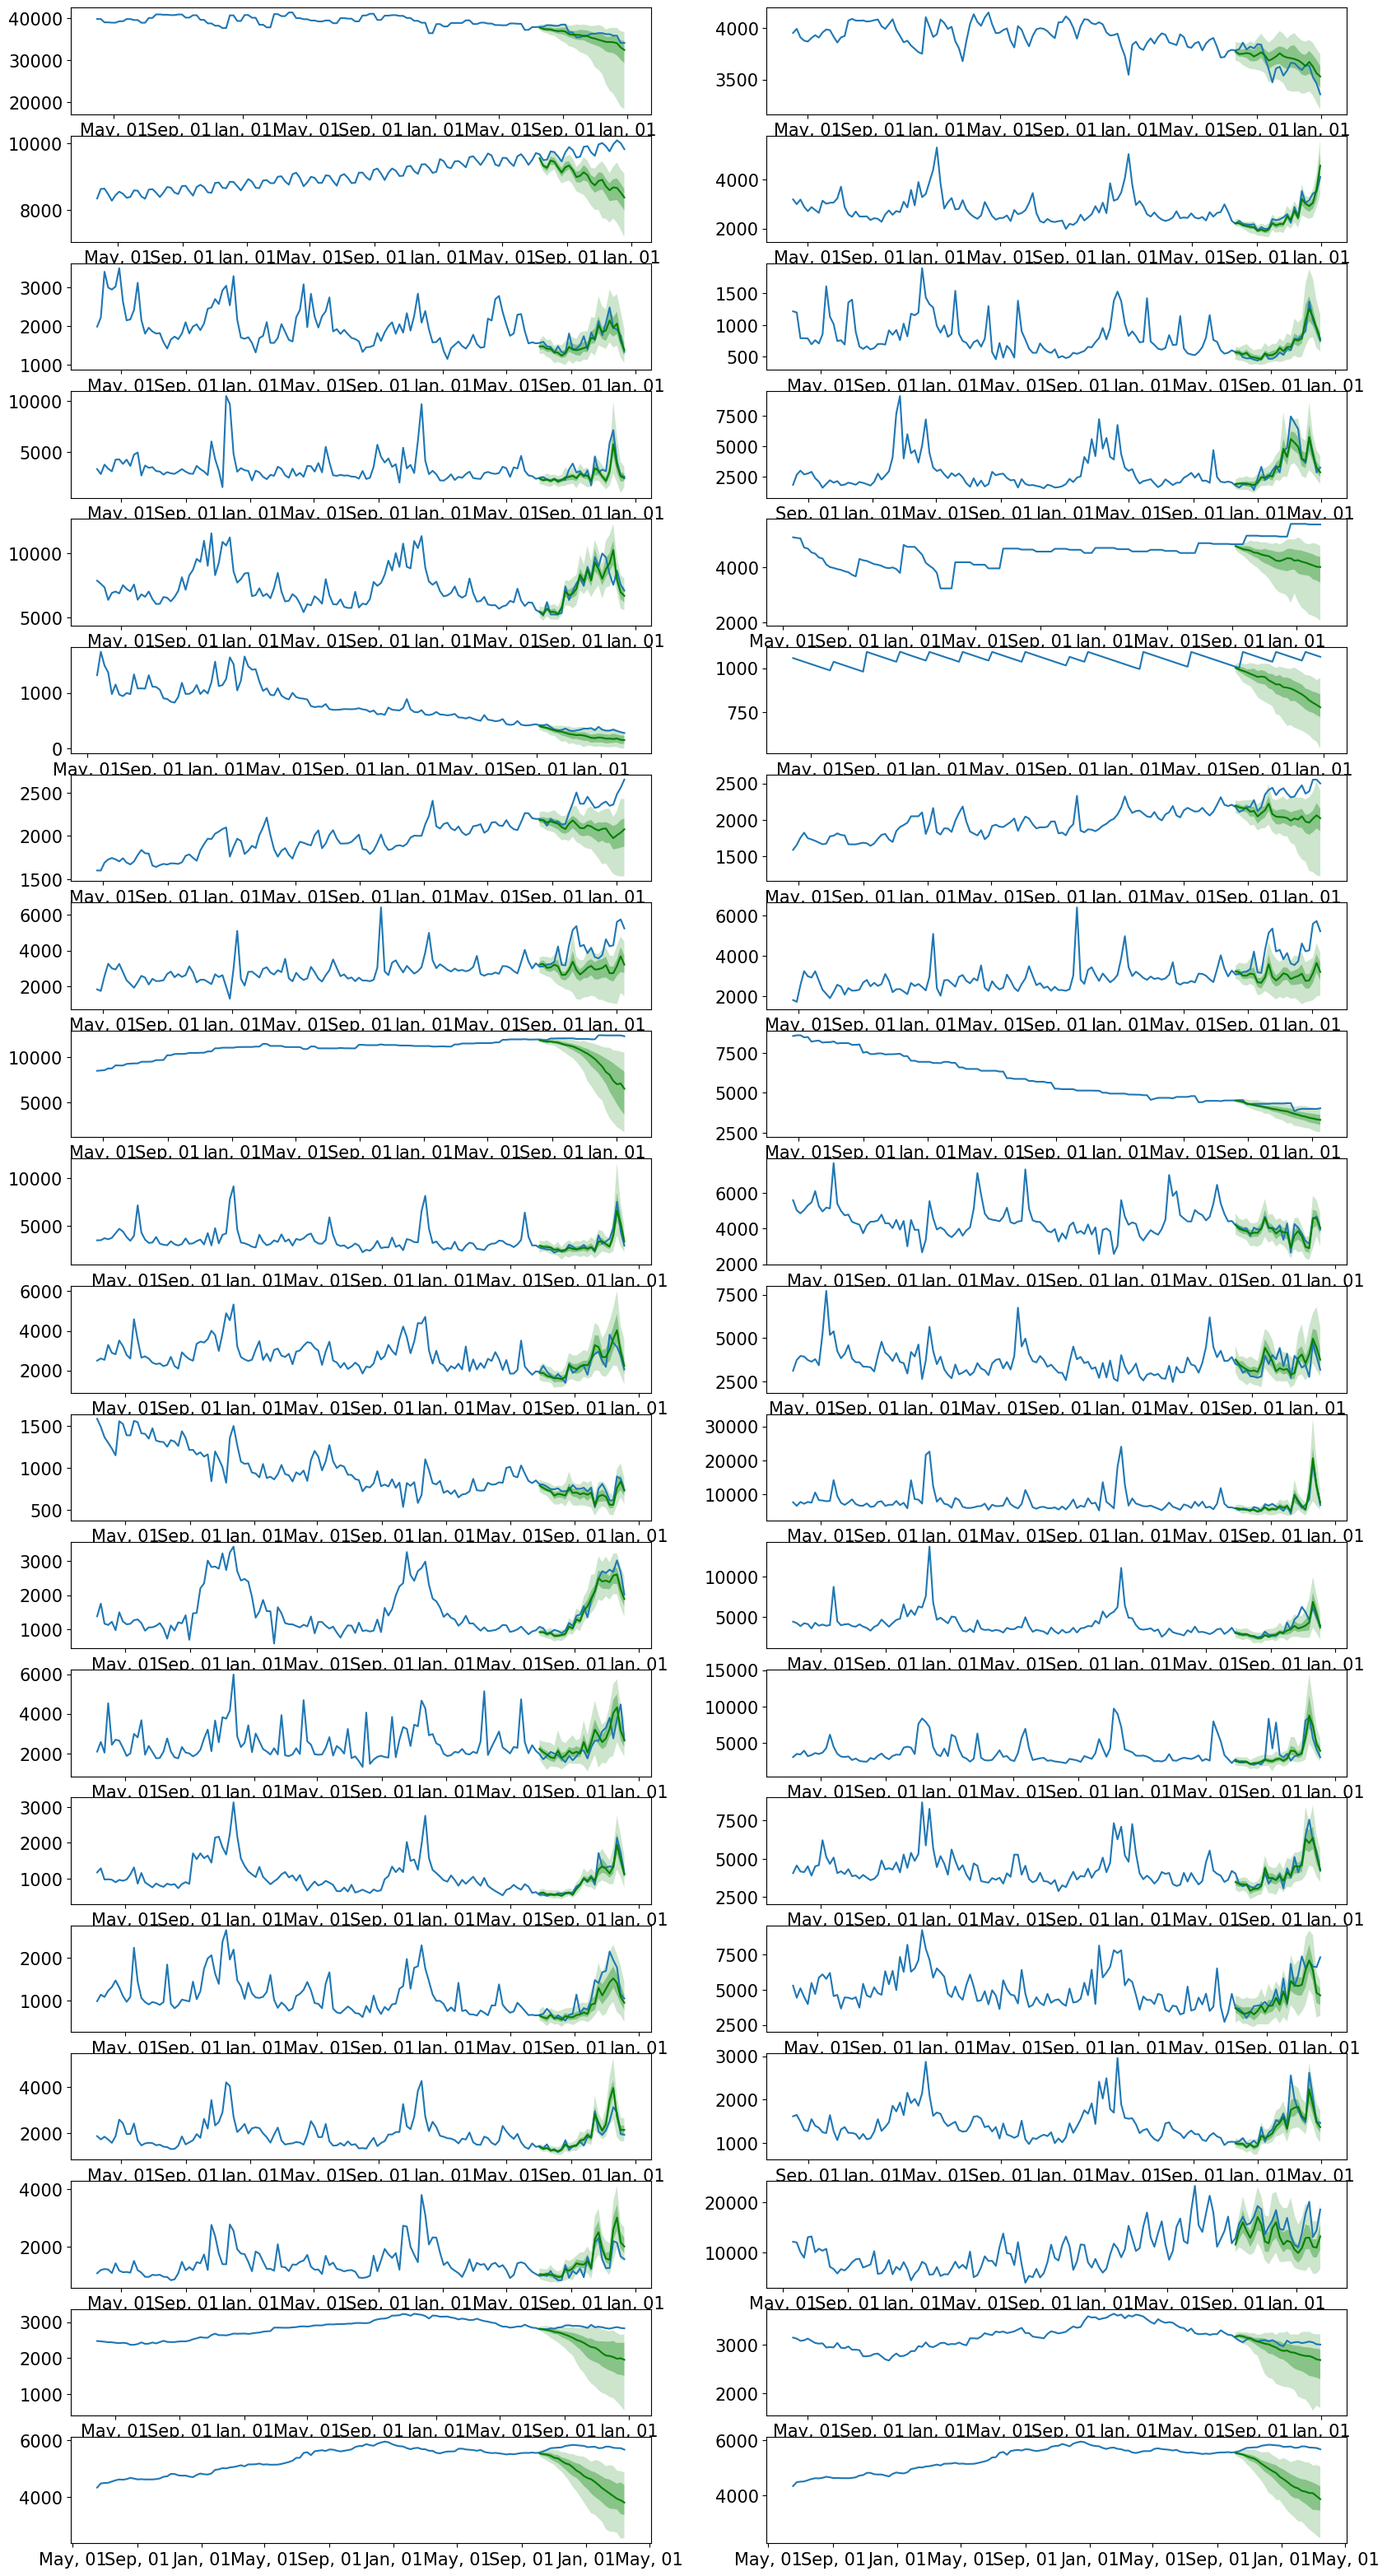

In [7]:
print(getCPRS(test_ds, predictor, )) # activated lr_scheduler (cosine annealing, T_max=10)
# CRPS: 0.10545857256570328

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]


Running evaluation: 359it [00:00, 3683.87it/s]
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up 

0.08187810156773152


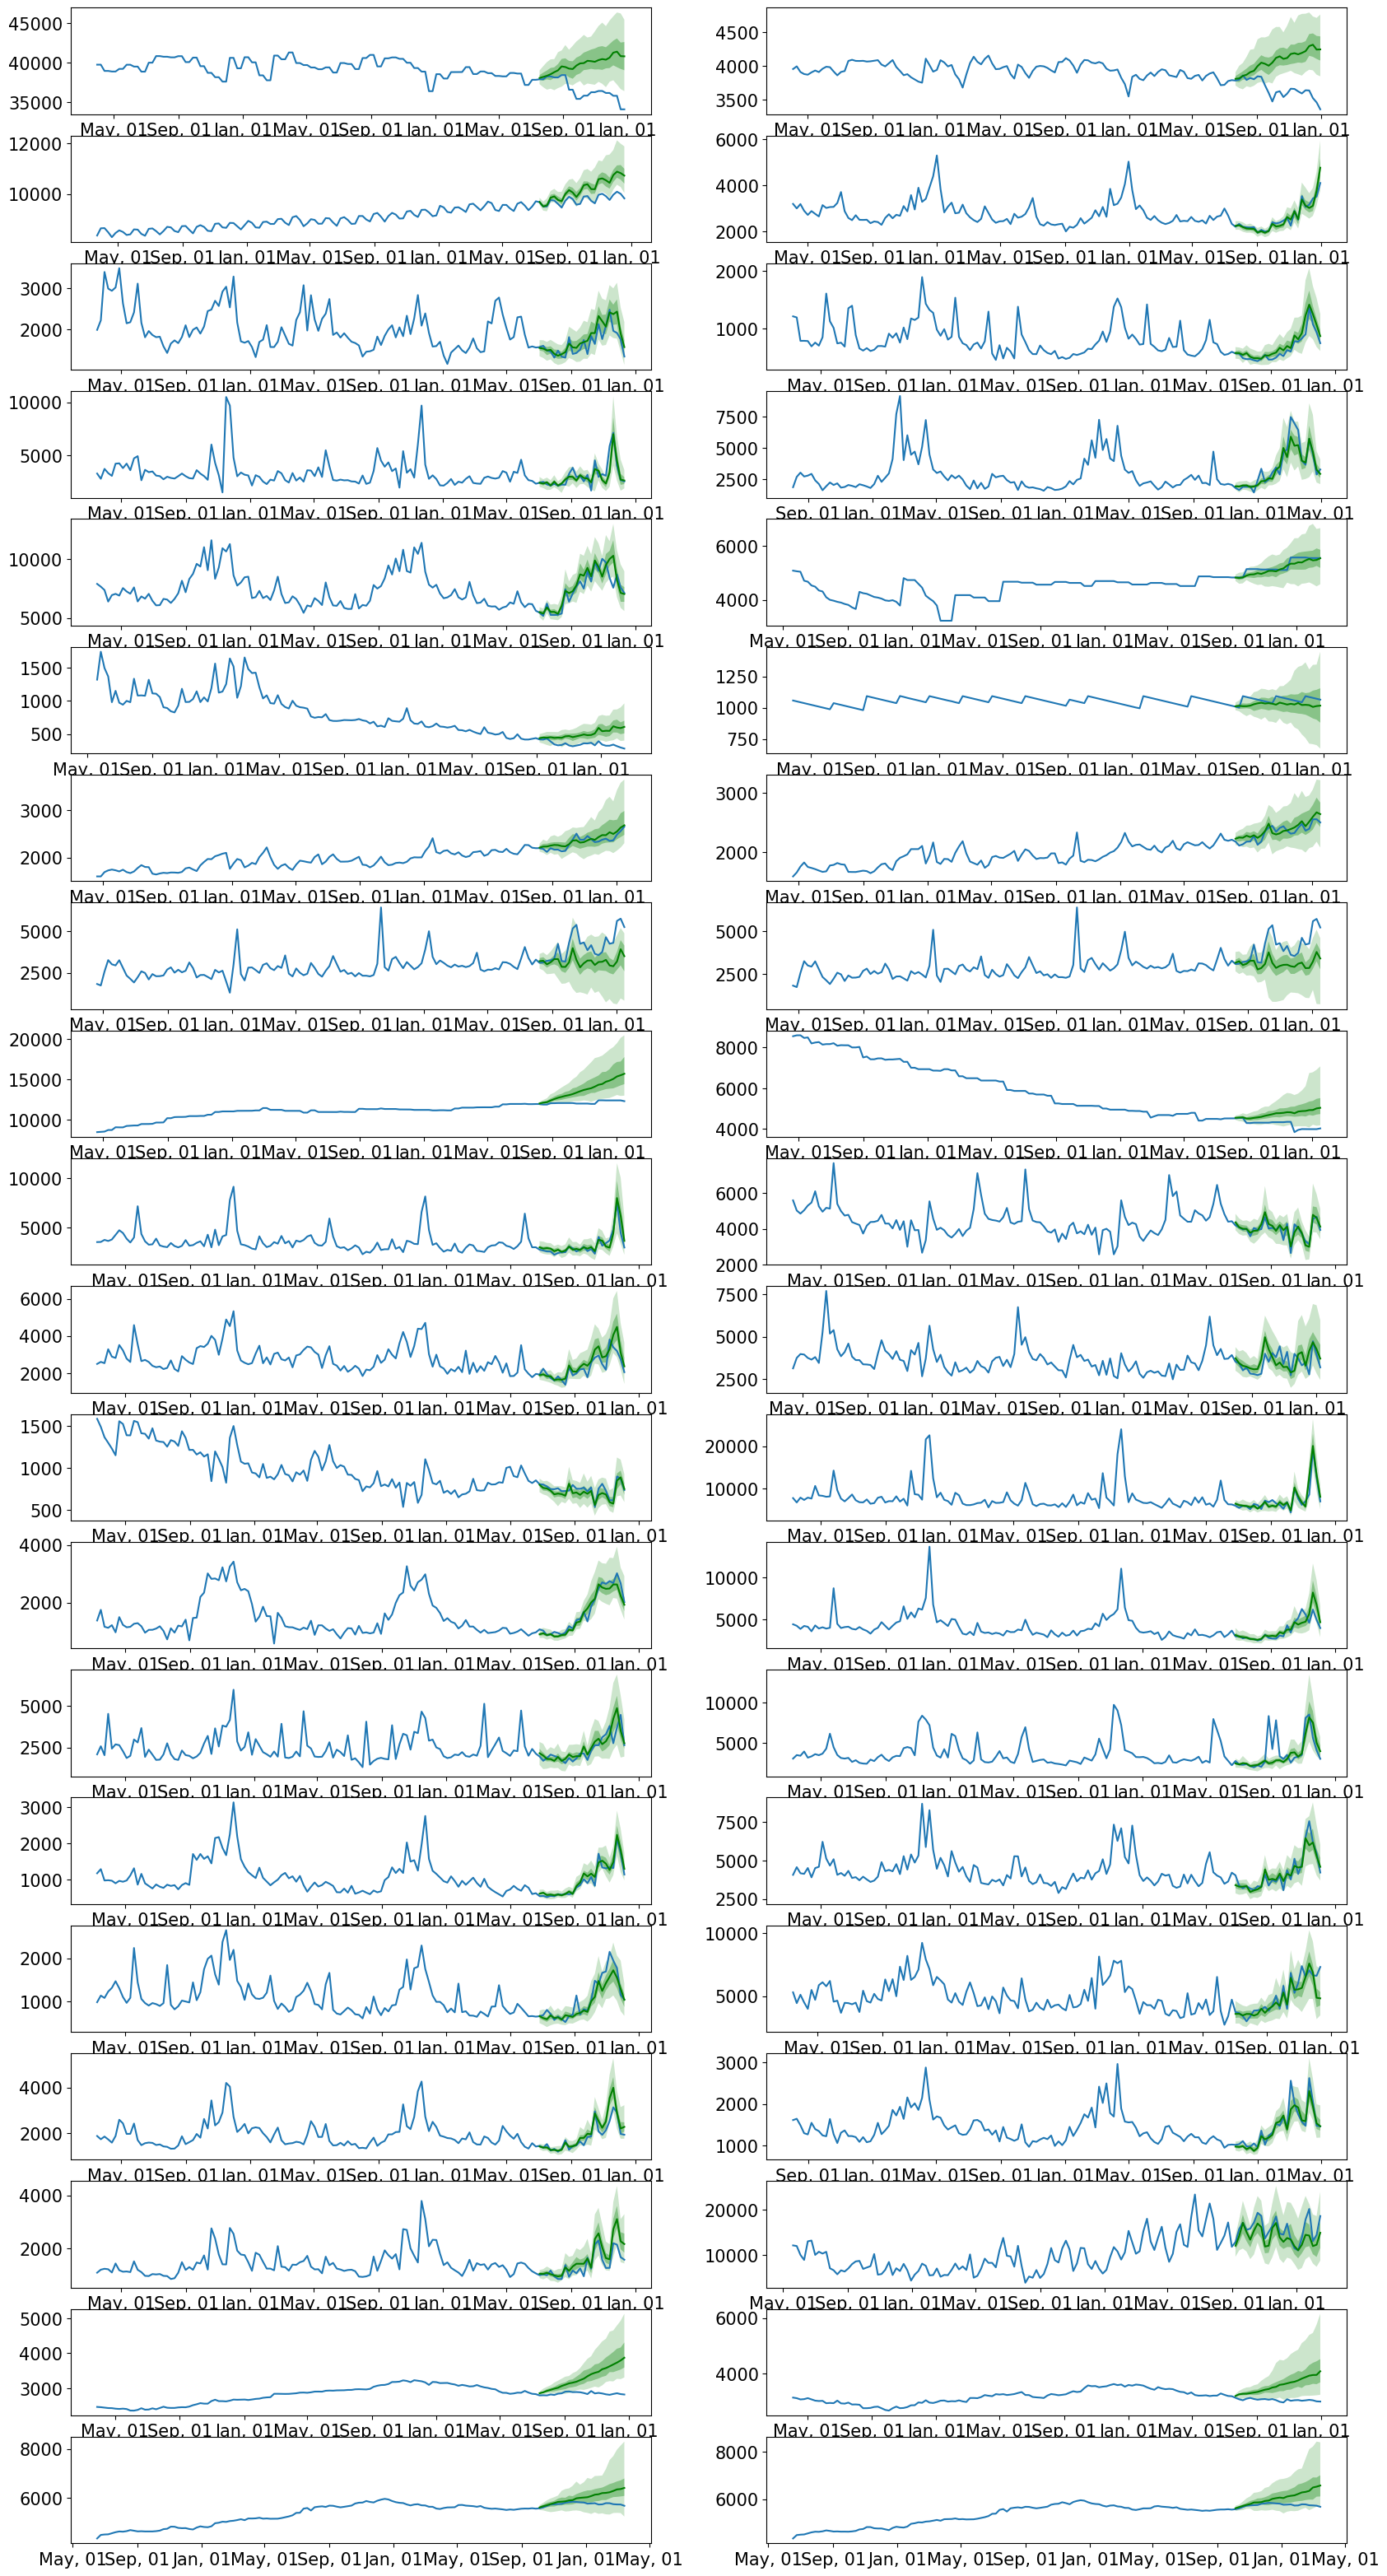

In [10]:
print(getCPRS(test_ds, predictor, )) # activated lr_scheduler (cosine annealing, T_max=7500)
# CRPS: 0.08187810156773152

Forecasting batches:   0%|          | 0/359 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/359 [00:00<?, ?it/s]


Running evaluation: 359it [00:00, 3545.41it/s]
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up 

0.06276508546695292


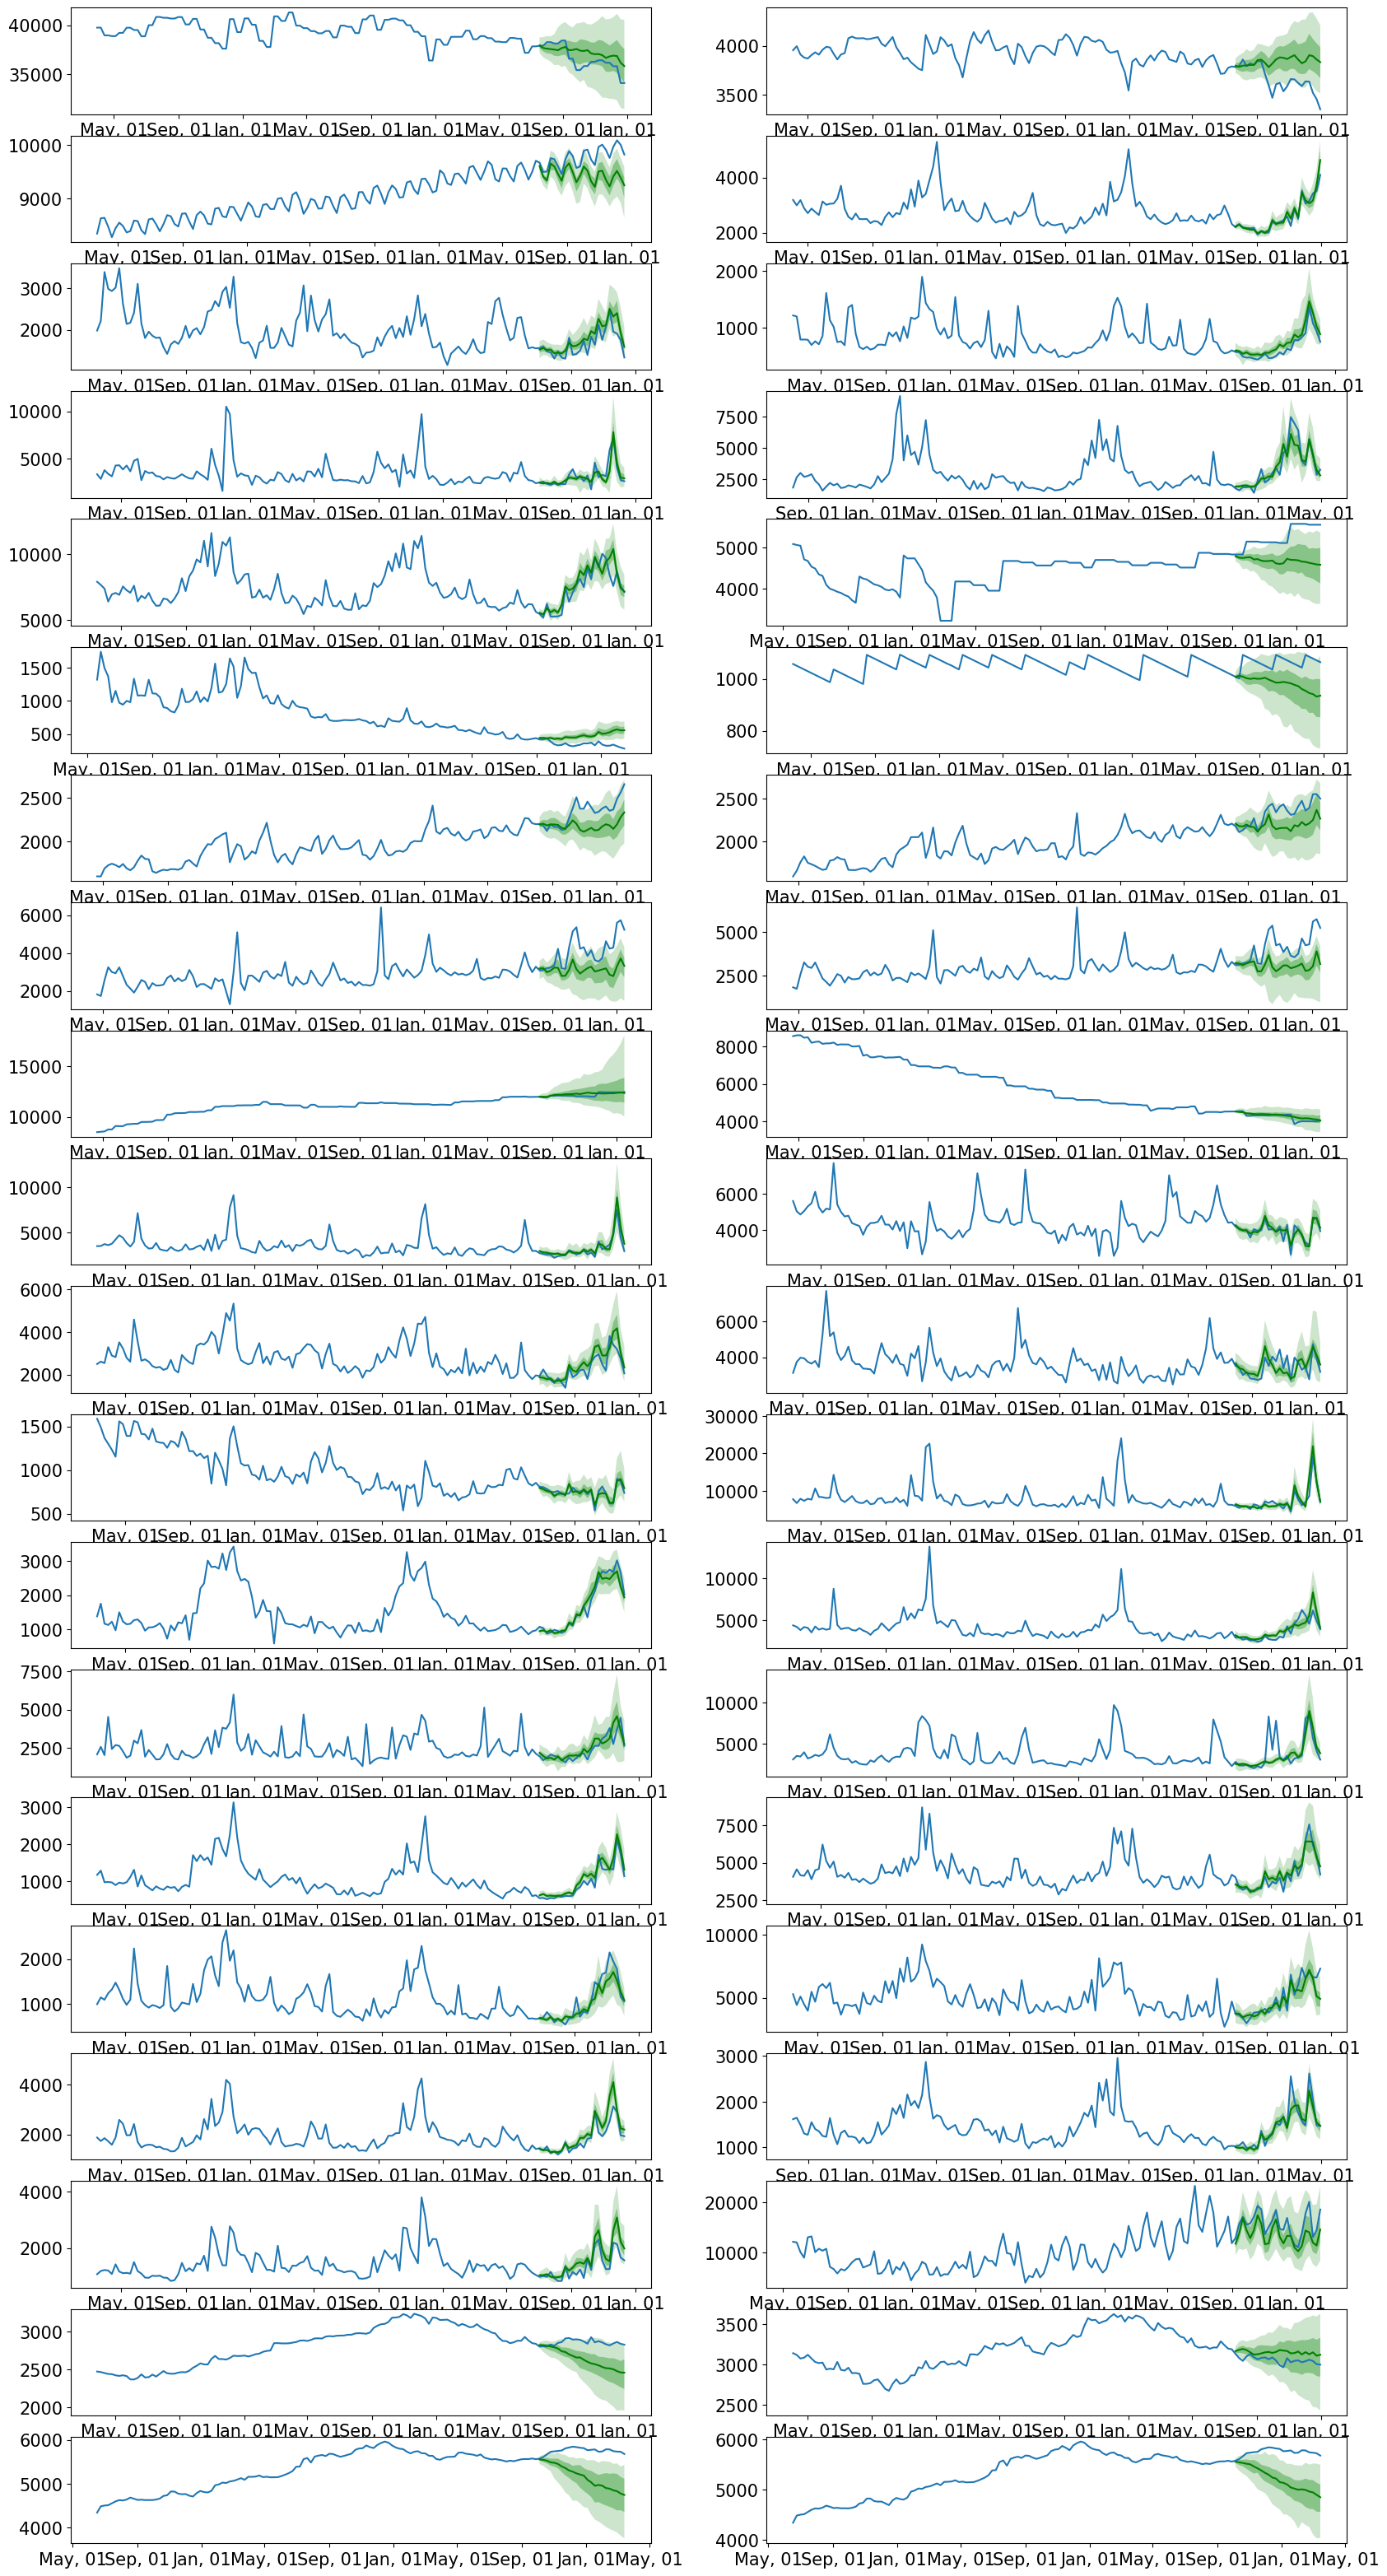

In [12]:
print(getCPRS(test_ds, predictor, )) # activated lr_scheduler (cosine annealing, T_max=500) 
# 500 = 50*10, making the learning rate follow a cosine cycle every 10 epochs.
# CRPS: 0.06276508546695292

### Grid search on lr (T_max=500)

In [6]:
def create_estimator(output_dir):
    config = wandb.config
    lr = config.lr
    context_length = 96
    batch_size = 32
    prediction_length = 24
    device = "cuda:0"
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=lr,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },
        batch_size=batch_size,
        num_parallel_samples=100,
        trainer_kwargs={"max_epochs": 150},
    #    log_train_loss=True, 
    )

    return estimator

In [9]:
# Define the search space
sweep_config = {
    "method": "grid",
    "parameters": {
        "lr": {"values": [10e-3, 10e-4 ,10e-5, 10e-6]}, # bigger magnitude 10-2 ... 10-6, lr_scheduler
    }
}
sweep_id = wandb.sweep(sweep_config, project="lag_llama_26_06")

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fbb7d8ca700>
Traceback (most recent call last):
  File "/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 

KeyboardInterrupt



In [7]:
def train():
    with wandb.init():
        estimator = create_estimator(output_dir=".")
        predictor = estimator.train(train_ds, cache_data=False, shuffle_buffer_length=1000)
        CPRS = getCPRS(train_ds, predictor, num_samples=100)
        wandb.log({"CPRS": CPRS})
        wandb.finish() # must-have, otherwise w&b doesn't know when a search is finished and thus can't proceed with the next search

In [ ]:
print(getCPRS(test_ds, predictor, )) # activated lr_scheduler (cosine annealing, T_max=500) 
# CRPS: 

In [10]:
# Start the sweep agent 
wandb.agent(sweep_id, train) 

wandb: Ctrl + C detected. Stopping sweep.


### Compare with zero-shot results

In [ ]:
def get_lag_llama_predictions(dataset, 
                              prediction_length, 
                              device, 
                              context_length=32, 
                              use_rope_scaling=False, 
                              num_samples=100):
    
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [ ]:
forecasts, tss = get_lag_llama_predictions(test_ds, prediction_length, torch.device(device))
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
print(agg_metrics['mean_wQuantileLoss'])

In [ ]:
plt.figure(figsize=(20, 60))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 21):
    ax = plt.subplot(11, 2, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", ) # only shows the last 4 prediction lengths
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()